In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_excel("forecasting_monthly_data.xlsx")
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(['Store', 'Month'])

In [3]:
results = []

In [4]:
for store_id in df['Store'].unique():
    store_data = df[df['Store'] == store_id].copy()
    store_data.set_index('Month', inplace=True)
    store_data = store_data.asfreq('MS')  # Ensure monthly frequency

    # Split into training and October test
    if 10 not in store_data.index.month:
        print(f"⚠️ HW skipped Store {store_id}: No October data.")
        continue

    october = store_data[store_data.index.month == 10]
    train = store_data[store_data.index.month != 10]

    if len(train) < 6:
        print(f"⚠️ HW skipped Store {store_id}: Not enough training data.")
        continue

    try:
        model = ExponentialSmoothing(train['Monthly_Sales'], seasonal='add', seasonal_periods=12)
        fit = model.fit(optimized=True)

        # Forecast October
        forecast = fit.forecast(1).values[0]
        actual = october['Monthly_Sales'].values[0]

        # MAPE
        train_pred = fit.fittedvalues
        train_mape = mean_absolute_percentage_error(train['Monthly_Sales'], train_pred) * 100
        test_mape = mean_absolute_percentage_error([actual], [forecast]) * 100

        results.append({
            'Store': store_id,
            'Forecast_Month': october.index[0],
            'Actual_Sales': actual,
            'Forecasted_Sales': forecast,
            'Train_MAPE': round(train_mape, 2),
            'Test_MAPE': round(test_mape, 2),
            'Model_Used': 'Holt-Winters'
        })

    except Exception as e:
        print(f"⚠️ HW failed for Store {store_id}: {e}")
        continue


c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\LopamudraMohapatra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Lopamud

In [5]:
forecast_df = pd.DataFrame(results)
forecast_df.to_excel("hw_october_forecast.xlsx", index=False)
print("✅ Holt-Winters October forecasting complete.")

✅ Holt-Winters October forecasting complete.


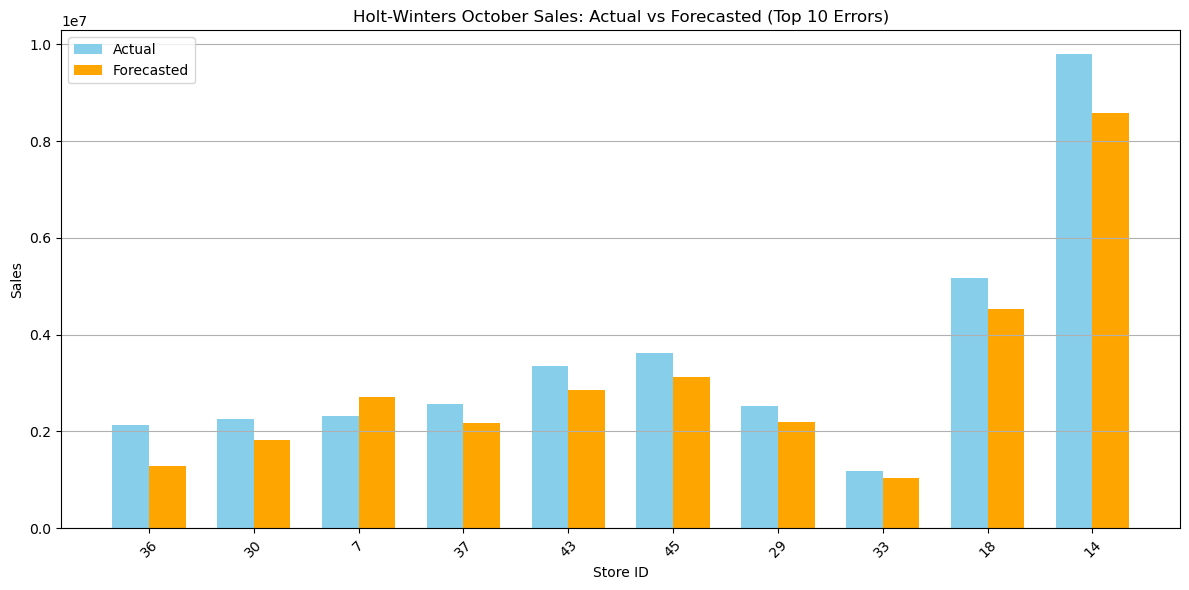

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Test MAPE and take top N
top_n = 10
plot_df = forecast_df.sort_values("Test_MAPE", ascending=False).head(top_n)

x = np.arange(len(plot_df))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, plot_df['Actual_Sales'], width, label='Actual', color='skyblue')
plt.bar(x + width/2, plot_df['Forecasted_Sales'], width, label='Forecasted', color='orange')

plt.xticks(x, plot_df['Store'], rotation=45)
plt.ylabel('Sales')
plt.xlabel('Store ID')
plt.title(f'Holt-Winters October Sales: Actual vs Forecasted (Top {top_n} Errors)')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
